In [ ]:
!pip install odc-stats==1.0.6 --upgrade

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd

import datacube
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

## Test plugin without odc-stats

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:32947 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [4]:
lat, lon = 34.5117, -5.9119
buffer = 0.05
# Set the range of dates for the climatology
time_range = ('1985', '2020')
resolution = (-60, 60)

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [5]:
# display_map(x=lon_range, y=lat_range)

In [6]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir','pixel_quality'],
    'group_by':'solar_day'
#     'dask_chunks':dask_chunks
}

### grab data so we can use the geobox parameter to mimic a 'task'

In [7]:
task = dc.load(product='ls8_sr', dask_chunks={}, **query)

### grab lists of datatsets to mimic .db files

In [8]:
dss = dc.find_datasets(product=['ls5_sr', 'ls7_sr', 'ls8_sr'], **query)

### set up an example config

In [9]:
config = dict(
    resampling="bilinear",
    bands=["red", "nir"],
    mask_band="QA_PIXEL",
    harmonization_slope=0.988,
    harmonization_intercept= -0.015,
    mask_filters=[["opening", 5], ["dilation", 5]],
    flags_ls57=dict(cloud="high_confidence", cloud_shadow="high_confidence"),
    flags_ls8=dict(
        cloud="high_confidence",
        cloud_shadow="high_confidence",
        cirrus="high_confidence",
    ),
)

### Run the plugin code

In [10]:
x=NDVIClimatology(**config)
ndvi = x.input_data(dss, task.geobox)
result = x.reduce(ndvi).compute()
print(result)

<xarray.Dataset>
Dimensions:             (y: 177, x: 162)
Coordinates:
  * y                   (y) float64 4.153e+06 4.153e+06 ... 4.142e+06 4.142e+06
  * x                   (x) float64 -5.752e+05 -5.752e+05 ... -5.656e+05
    spatial_ref         int32 6933
Data variables: (12/36)
    ndvi_clim_mean_jan  (y, x) float32 0.5833 0.5732 0.5588 ... 0.2083 0.462
    ndvi_clim_mean_feb  (y, x) float32 0.6778 0.6818 0.6721 ... 0.2393 0.4923
    ndvi_clim_mean_mar  (y, x) float32 0.6529 0.6473 0.651 ... 0.2156 0.4416
    ndvi_clim_mean_apr  (y, x) float32 0.484 0.4736 0.4693 ... 0.2361 0.4272
    ndvi_clim_mean_may  (y, x) float32 0.3625 0.3684 0.383 ... 0.1344 0.36
    ndvi_clim_mean_jun  (y, x) float32 0.2798 0.2766 0.2806 ... 0.1062 0.3015
    ...                  ...
    count_jul           (y, x) float64 9.0 9.0 9.0 11.0 ... 11.0 11.0 11.0 10.0
    count_aug           (y, x) float64 17.0 17.0 17.0 17.0 ... 17.0 16.0 15.0
    count_sep           (y, x) float64 18.0 18.0 19.0 19.0 ... 16.0 

### Plot

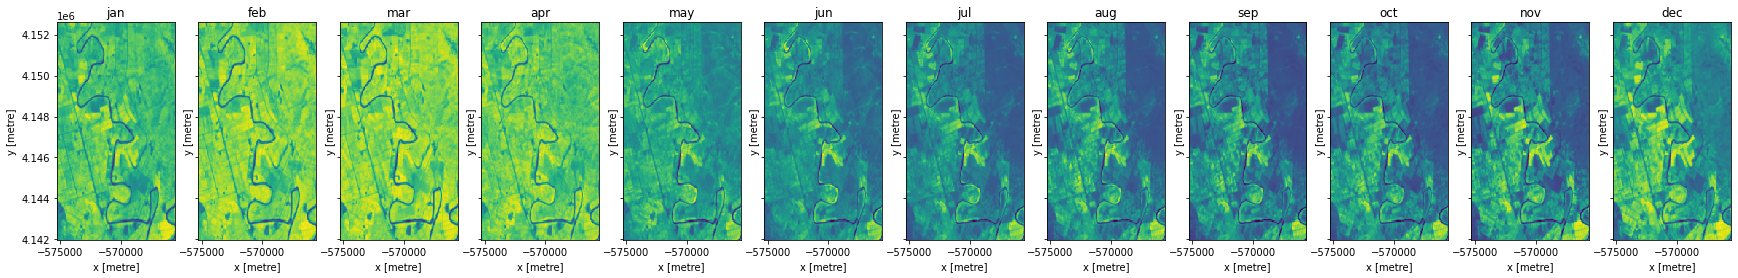

In [11]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_mean_'+j].plot.imshow(ax=ax[i], add_colorbar=False, vmin=0)
    ax[i].set_title(j)

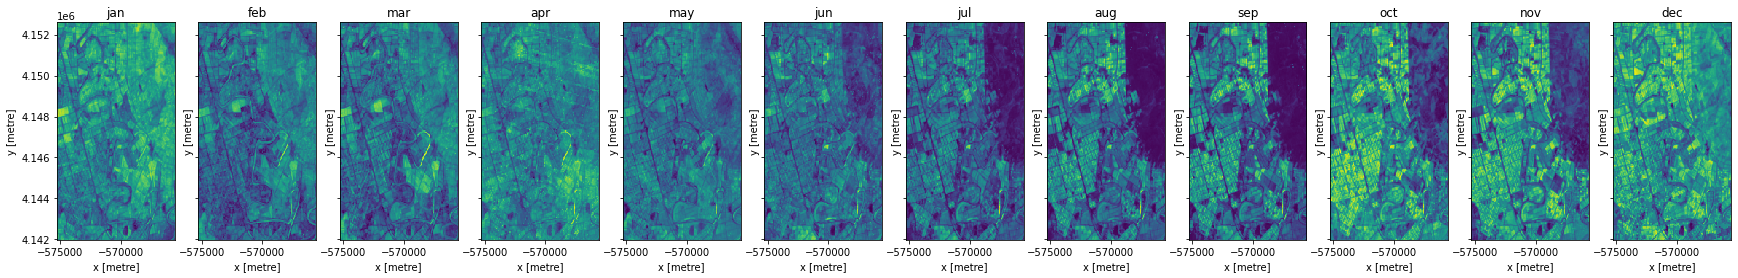

In [12]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['ndvi_clim_std_'+j].plot.imshow(ax=ax[i], )
    ax[i].set_title(j)

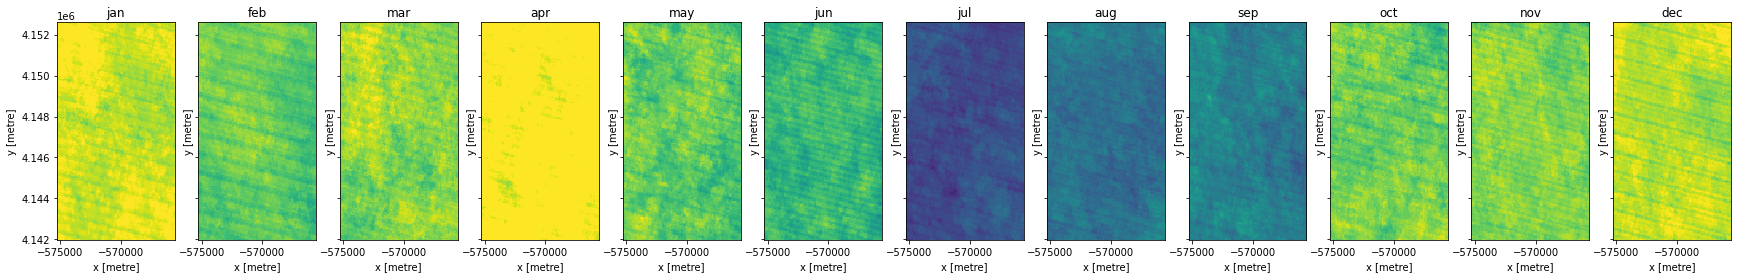

In [15]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['count_'+j].plot.imshow(ax=ax[i], vmin = 0, vmax=40, add_colorbar=False)
    ax[i].set_title(j)

## Test plugin with odc-stats

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [ ]:
import os

### Generate tasks etc

In [ ]:
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls7_sr-ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'
# !odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2014--P2Y ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'

### Try running odc-stats using the config yaml and external plugin

In [ ]:
%%time
os.system("odc-stats run "\
          "ls7_sr-ls8_sr_2014--P2Y.db "\
          "--config=ndvi_climatology.yaml "\
          "--resolution=60 "\
          "--threads=4 "\
          "--memory-limit=29Gi "\
          "--location=file:///home/jovyan/git/deafrica-sandbox-notebooks/HLS/{product}/{version}/ "+str(1200)
         )

In [ ]:
# !odc-stats run ls7_sr-ls8_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=80 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} 1202